# Pipeline All Models

In [1]:
import numpy as np
import cv2
import sklearn
import pickle
import matplotlib.pyplot as plt

In [2]:
# face detection
face_detector_model = cv2.dnn.readNetFromCaffe('../models/deploy.prototxt.txt','../models/res10_300x300_ssd_iter_140000.caffemodel')
# feature extraction
face_feature_model = cv2.dnn.readNetFromTorch('../models/openface.nn4.small2.v1.t7')
# face recognition
face_recognition_model = pickle.load(open('../models/machinelearning_face_person_identity.pkl',mode='rb'))
# emotion recognition model 
emotion_recognition_model = pickle.load(open('../models/machinelearning_face_emotion_identity.pkl',mode='rb'))

In [3]:
def calculate_font_size(image_width, base_size=20):
    return base_size * (image_width / 5000)

In [3]:
def pipeline_model(path):
    # pipeline model
    img = cv2.imread(path)
    Image = img.copy()
    h,w = img.shape[:2]
    # face detection
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=False,crop=False)
    face_detector_model.setInput(img_blob)
    detections = face_detector_model.forward()
    
        
    #machine results
    machinlearning_result = dict(face_detect_score = [],
                                 face_name = [],
                                 face_name_score = [],
                                 emotion_name = [],
                                 emotion_name_score = [],
                                 count = [])
    
    count = 1 
    
    if len(detections) > 0:
        for i , confidence in enumerate(detections[0,0,:,2]):
            if confidence > 0.5:
                box = detections[0,0,i,3:7]*np.array([w,h,w,h])
                starx,stary,endx,endy = box.astype(int)
                
                cv2.rectangle(Image,(starx,stary),(endx,endy),(0,255,0))
                
                # features extraction 
                face_roi = img[stary:endy, starx:endx]
                face_blob = cv2.dnn.blobFromImage(face_roi,1/255,(96,96),(0,0,0),swapRB=True,crop=True)
                face_feature_model.setInput(face_blob)
                vectors = face_feature_model.forward()
                
                # predict with machine learing
                face_name = face_recognition_model.predict(vectors)[0]
                face_score = face_recognition_model.predict_proba(vectors).max()
                # Emotion
                emotion_name=emotion_recognition_model.predict(vectors)[0]
                emotion_score=emotion_recognition_model.predict_proba(vectors).max()
                
                
                text_face = '{} : {: .0f} %'.format(face_name, 100*face_score)
                text_emotion = ' {} : {: .0f} %'.format(emotion_name,100*emotion_score)
                
                
                cv2.putText(Image,text_face,(starx,stary),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
                cv2.putText(Image,text_emotion,(starx,endy),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
                
                machinlearning_result['count'].append(count)
                machinlearning_result['face_detect_score'].append(confidence)
                machinlearning_result['face_name'].append(face_name)
                machinlearning_result['face_name_score'].append(face_score) 
                machinlearning_result['emotion_name'].append(emotion_name) 
                machinlearning_result['emotion_name_score'].append(emotion_score) 
                
                count += 1 
                
    return machinlearning_result



In [4]:
results = pipeline_model('../image/joe_trump_obama.jpg')
results

{'face_detect_score': [0.99988604, 0.99967766, 0.87867606],
 'face_name': ['Joe Biden', 'Donald Trump', 'Barack Obama'],
 'face_name_score': [0.5490528276280632,
  0.7088127962542038,
  0.7331556422231428],
 'emotion_name': ['angry', 'angry', 'sad'],
 'emotion_name_score': [0.24618418572607914,
  0.3064776482638963,
  0.2783818300271376],
 'count': [1, 2, 3]}

# pipelin con matplotlib

In [5]:
def pipeline_model_mathplotlib(path):
    # pipeline model
    img = cv2.imread(path)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # face detection
    img_blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123), swapRB=False, crop=False)
    face_detector_model.setInput(img_blob)
    detections = face_detector_model.forward()

    if len(detections) > 0:
        for i, confidence in enumerate(detections[0, 0, :, 2]):
            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                starx, stary, endx, endy = box.astype(int)
                
                # features extraction 
                face_roi = img[stary:endy, starx:endx]
                face_blob = cv2.dnn.blobFromImage(face_roi, 1/255, (96, 96), (0, 0, 0), swapRB=True, crop=True)
                face_feature_model.setInput(face_blob)
                vectors = face_feature_model.forward()
                
                # predict with machine learning
                face_name = face_recognition_model.predict(vectors)[0]
                face_score = face_recognition_model.predict_proba(vectors).max()
                # Emotion
                emotion_name = emotion_recognition_model.predict(vectors)[0]
                emotion_score = emotion_recognition_model.predict_proba(vectors).max()
                
                text_face = '{} : {: .0f} %'.format(face_name, 100 * face_score)
                text_emotion = ' {} : {: .0f} %'.format(emotion_name, 100 * emotion_score)
                
                # Calculate font size
                font_size = calculate_font_size(w, base_size=20)
                
                # Create a figure and an axis
                fig, ax = plt.subplots()
                ax.imshow(image_rgb)
                ax.axis('off')
                
                # Add text annotations
                ax.text(starx, stary - 10, text_face, fontsize=font_size, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5))
                ax.text(starx, endy + 30, text_emotion, fontsize=font_size, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5))
                
    
    return image_rgb

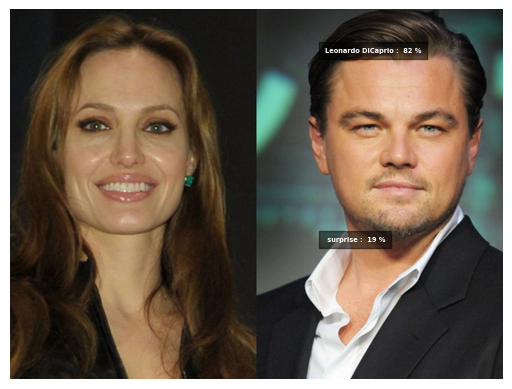

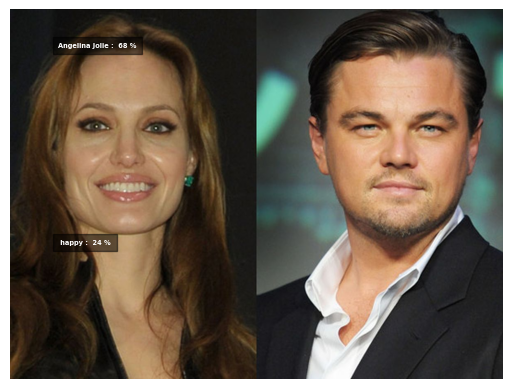

In [11]:
#image = pipeline_model('../image/rober downer jr .jpg')

#cv2.imshow('image',image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

image_rgb = pipeline_model_mathplotlib('../image/test_images.jpg')
plt.imshow(image_rgb)
plt.axis('off')
plt.show()